**PHASE 4: ANALYSIS - Research Question 4**

Purpose: Identify small but rapidly growing research niches  
Input: cluster_profiles_300d.pkl, cluster_profiles_500d.pkl, metadata  
Output: Growing niche identification, growth trajectory analysis  
Algorithm: Temporal analysis, growth rate calculation, niche scoring  
ML Involved: ✗ NO - Pure analysis of clustering results  
Runtime: ~10-15 minutes  

Research Question 4:
"What are the small but rapidly growing research niches that represent emerging areas of study?"

Approach:
- Identify small clusters (niche size threshold)
- Calculate growth rates (recent vs older papers)
- Measure recency (concentration of recent work)
- Assess topic coherence (distinctiveness)
- Rank by composite niche score
- Compare both paths' niche detection capabilities

In [1]:
# imports

import pandas as pd
import numpy as np
import os
import sys
import joblib
from collections import Counter
from datetime import datetime
from scipy.stats import entropy
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# add project root

sys.path.append('..')
from config import RANDOM_STATE

In [2]:
# load cluster profiles from both paths

print("Loading cluster profiles...")
profiles_300d = joblib.load('data/processed/cluster_profiles_300d.pkl')
profiles_500d = joblib.load('data/processed/cluster_profiles_500d.pkl')
print(f"✓ 300d: {profiles_300d['n_clusters']} clusters")
print(f"✓ 500d: {profiles_500d['n_clusters']} clusters")

# load cluster labels

labels_300d = pd.read_pickle('data/processed/cluster_labels_300d.pkl')
labels_500d = pd.read_pickle('data/processed/cluster_labels_500d.pkl')
print(f"✓ Cluster labels loaded")

# load metadata

df_metadata = pd.read_pickle('data/processed/arxiv_text_cleaned.pkl')
print(f"✓ Metadata: {len(df_metadata):,} papers")

# merge with cluster assignments

df_300d = df_metadata.merge(labels_300d, on='id', how='left')
df_500d = df_metadata.merge(labels_500d, on='id', how='left')
print(f"✓ Merged dataframes created")

print("DATA LOADED - READY FOR ANALYSIS")

Loading cluster profiles...
✓ 300d: 50 clusters
✓ 500d: 50 clusters
✓ Cluster labels loaded
✓ Metadata: 2,384,622 papers
✓ Merged dataframes created
DATA LOADED - READY FOR ANALYSIS


In [3]:
print("RESEARCH QUESTION 4: GROWING NICHES")

print("Question: What are the small but rapidly growing research niches")
print("          that represent emerging areas of study?\n")

# calculate comprehensive niche scores

print("Calculating niche scores for all clusters...\n")

def calculate_niche_metrics(profiles, df_with_clusters, cluster_id):
    """
    Calculate metrics for identifying growing niches
    
    Components:
    1. Size (small = niche)
    2. Growth rate (recent vs older)
    3. Recency (concentration in recent years)
    4. Distinctiveness (unique topic)
    5. Acceleration (growth trend)
    """
    cluster_papers = df_with_clusters[df_with_clusters['cluster_id'] == cluster_id]
    
    if len(cluster_papers) < 20:  # too small to analyze reliably
        return None
    
    # 1. size score (smaller = more niche-like)
    size = len(cluster_papers)
    total_papers = len(df_with_clusters)
    size_ratio = size / total_papers
    
    # normalize: 0.1% = 1.0, 5% = 0.0 (linear scale)
    size_score = max(0, min(1, (0.05 - size_ratio) / 0.049))
    
    # 2. growth rate (from quality metrics)
    growth_rate = profiles['quality'][cluster_id]['growth_rate']
    # normalize: 0% = 0.0, 200% = 1.0
    growth_score = max(0, min(1, growth_rate / 2.0))
    
    # 3. recency (from temporal metrics)
    recent_ratio = profiles['temporal'][cluster_id]['recent_ratio']
    # already 0-1 scale
    recency_score = recent_ratio
    
    # 4. distinctiveness (from quality metrics)
    distinctiveness = profiles['quality'][cluster_id]['distinctiveness']
    # already 0-1 scale (typically)
    distinct_score = min(1, distinctiveness)
    
    # 5. acceleration (compare recent growth to overall)
    years = cluster_papers['year'].values
    
    # split into periods
    cutoff_2015 = 2015
    cutoff_2020 = 2020
    
    pre_2015 = sum(years < cutoff_2015)
    mid_period = sum((years >= cutoff_2015) & (years < cutoff_2020))  # 2015-2019
    post_2020 = sum(years >= cutoff_2020)
    
    # calculate growth acceleration
    if pre_2015 > 0 and mid_period > 0:
        early_rate = mid_period / pre_2015
        if post_2020 > 0 and mid_period > 0:
            late_rate = post_2020 / mid_period
            acceleration = late_rate / early_rate if early_rate > 0 else 1.0
        else:
            acceleration = 1.0
    else:
        acceleration = 1.0
    
    # normalize acceleration: 1.0 = 0.0, 3.0+ = 1.0
    accel_score = max(0, min(1, (acceleration - 1.0) / 2.0))
    
    # 6. topic coherence (inverse of category entropy)
    cat_entropy = profiles['quality'][cluster_id]['domain_diversity']
    # lower entropy = more coherent = better for niche
    # normalize: 0.0 = 1.0, 2.0 = 0.0
    coherence_score = max(0, 1 - cat_entropy / 2.0)
    
    # calculate composite niche score

    # weighted combination emphasizing growth and recency
    niche_score = (
        0.15 * size_score +        # Small size
        0.30 * growth_score +      # High growth rate
        0.25 * recency_score +     # Recent papers
        0.10 * distinct_score +    # Unique content
        0.15 * accel_score +       # Accelerating growth
        0.05 * coherence_score     # Topic coherence
    )
    
    # additional metrics for characterization

    median_year = profiles['temporal'][cluster_id]['median_year']
    earliest_year = profiles['temporal'][cluster_id]['earliest_year']
    latest_year = profiles['temporal'][cluster_id]['latest_year']
    
    return {
        'niche_score': niche_score,
        'size': size,
        'size_ratio': size_ratio,
        'size_score': size_score,
        'growth_rate': growth_rate,
        'growth_score': growth_score,
        'recent_ratio': recent_ratio,
        'recency_score': recency_score,
        'distinctiveness': distinctiveness,
        'distinct_score': distinct_score,
        'acceleration': acceleration,
        'accel_score': accel_score,
        'coherence_score': coherence_score,
        'median_year': median_year,
        'earliest_year': earliest_year,
        'latest_year': latest_year,
        'pre_2015_count': int(pre_2015),
        'mid_period_count': int(mid_period),
        'post_2020_count': int(post_2020)
    }

# calculate for 300d

print("Analyzing 300d niches...")
niches_300d = {}
for cid in range(profiles_300d['n_clusters']):
    result = calculate_niche_metrics(profiles_300d, df_300d, cid)
    if result is not None:
        niches_300d[cid] = result
    if (cid + 1) % 10 == 0:
        print(f"  Processed {cid + 1}/{profiles_300d['n_clusters']} clusters")

# calculate for 500d

print("\nAnalyzing 500d niches...")
niches_500d = {}
for cid in range(profiles_500d['n_clusters']):
    result = calculate_niche_metrics(profiles_500d, df_500d, cid)
    if result is not None:
        niches_500d[cid] = result
    if (cid + 1) % 10 == 0:
        print(f"  Processed {cid + 1}/{profiles_500d['n_clusters']} clusters")

print(f"\n✓ Niche scores calculated")
print(f"  300d: {len(niches_300d)} clusters analyzed")
print(f"  500d: {len(niches_500d)} clusters analyzed")

RESEARCH QUESTION 4: GROWING NICHES
Question: What are the small but rapidly growing research niches
          that represent emerging areas of study?

Calculating niche scores for all clusters...

Analyzing 300d niches...
  Processed 10/50 clusters
  Processed 20/50 clusters
  Processed 30/50 clusters
  Processed 40/50 clusters
  Processed 50/50 clusters

Analyzing 500d niches...
  Processed 10/50 clusters
  Processed 20/50 clusters
  Processed 30/50 clusters
  Processed 40/50 clusters
  Processed 50/50 clusters

✓ Niche scores calculated
  300d: 50 clusters analyzed
  500d: 50 clusters analyzed


In [4]:
# identify top growing niches

print("TOP GROWING RESEARCH NICHES")

# 300d top 15 niches
top_niches_300d = sorted(niches_300d.items(), 
                         key=lambda x: x[1]['niche_score'], reverse=True)[:15]

print("SVD-300d - Top 15 Growing Niches:")
print()

for rank, (cid, data) in enumerate(top_niches_300d, 1):
    top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:15]]
    top_cats = list(profiles_300d['top_categories'][cid]['primary_categories'].items())[:3]
    domains = profiles_300d['top_categories'][cid]['domains']
    
    print(f"{rank}. Cluster {cid} - Niche Score: {data['niche_score']:.3f}")
    print(f"   Size: {data['size']:,} papers ({data['size_ratio']*100:.2f}% of corpus)")
    print(f"   Growth rate: {data['growth_rate']*100:+.1f}%")
    print(f"   Recent papers (2020+): {data['recent_ratio']*100:.1f}%")
    print(f"   Acceleration: {data['acceleration']:.2f}x")
    print(f"   Temporal: {data['earliest_year']}-{data['latest_year']} (median: {data['median_year']:.0f})")
    print(f"   Distribution: Pre-2015={data['pre_2015_count']}, 2015-2019={data['mid_period_count']}, 2020+={data['post_2020_count']}")
    print(f"   Domains: {', '.join(f'{d}({c})' for d, c in list(domains.items())[:3])}")
    print(f"   Top categories: {', '.join(f'{cat}({cnt})' for cat, cnt in top_cats)}")
    print(f"   Key terms: {', '.join(top_terms[:12])}")
    print()

# 500d top 15 niches
top_niches_500d = sorted(niches_500d.items(), 
                         key=lambda x: x[1]['niche_score'], reverse=True)[:15]

print("\n" + "="*80)
print("SVD-500d - Top 15 Growing Niches:")
print()

for rank, (cid, data) in enumerate(top_niches_500d, 1):
    top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:15]]
    top_cats = list(profiles_500d['top_categories'][cid]['primary_categories'].items())[:3]
    domains = profiles_500d['top_categories'][cid]['domains']
    
    print(f"{rank}. Cluster {cid} - Niche Score: {data['niche_score']:.3f}")
    print(f"   Size: {data['size']:,} papers ({data['size_ratio']*100:.2f}% of corpus)")
    print(f"   Growth rate: {data['growth_rate']*100:+.1f}%")
    print(f"   Recent papers (2020+): {data['recent_ratio']*100:.1f}%")
    print(f"   Acceleration: {data['acceleration']:.2f}x")
    print(f"   Temporal: {data['earliest_year']}-{data['latest_year']} (median: {data['median_year']:.0f})")
    print(f"   Distribution: Pre-2015={data['pre_2015_count']}, 2015-2019={data['mid_period_count']}, 2020+={data['post_2020_count']}")
    print(f"   Domains: {', '.join(f'{d}({c})' for d, c in list(domains.items())[:3])}")
    print(f"   Top categories: {', '.join(f'{cat}({cnt})' for cat, cnt in top_cats)}")
    print(f"   Key terms: {', '.join(top_terms[:12])}")
    print()

TOP GROWING RESEARCH NICHES
SVD-300d - Top 15 Growing Niches:

1. Cluster 26 - Niche Score: 0.895
   Size: 38,393 papers (1.61% of corpus)
   Growth rate: +1674.7%
   Recent papers (2020+): 96.7%
   Acceleration: 12.73x
   Temporal: 2007-2025 (median: 2024)
   Distribution: Pre-2015=308, 2015-2019=948, 2020+=37137
   Domains: cs(37538), eess(213), q-bio(193)
   Top categories: cs.CL(21253), cs.LG(3291), cs.AI(3137)
   Key terms: llms, language, models, language models, reasoning, tasks, large, performance, model, knowledge, human, fine

2. Cluster 13 - Niche Score: 0.874
   Size: 10,888 papers (0.46% of corpus)
   Growth rate: +547.9%
   Recent papers (2020+): 94.7%
   Acceleration: 2.21x
   Temporal: 2007-2025 (median: 2024)
   Distribution: Pre-2015=57, 2015-2019=516, 2020+=10315
   Domains: cs(9791), eess(347), physics(193)
   Top categories: cs.AI(2235), cs.CY(2051), cs.HC(1606)
   Key terms: ai, human, research, systems, models, data, generative, challenges, learning, development,

In [ ]:
# analyze growth trajectories for top niches

print("GROWTH TRAJECTORY ANALYSIS")

def analyze_trajectory(df_with_clusters, cluster_id):
    """Calculate yearly paper counts for trajectory visualization"""
    cluster_papers = df_with_clusters[df_with_clusters['cluster_id'] == cluster_id]
    
    # count by year
    year_counts = cluster_papers['year'].value_counts().sort_index()
    
    # fill in missing years with 0
    min_year = year_counts.index.min()
    max_year = year_counts.index.max()
    all_years = range(int(min_year), int(max_year) + 1)
    
    trajectory = pd.Series(0, index=all_years)
    trajectory.update(year_counts)
    
    return trajectory

# analyze top 5 niches from each path for visualization
print("Calculating growth trajectories for top niches...\n")

trajectories_300d = {}
for cid, _ in top_niches_300d[:5]:
    trajectories_300d[cid] = analyze_trajectory(df_300d, cid)

trajectories_500d = {}
for cid, _ in top_niches_500d[:5]:
    trajectories_500d[cid] = analyze_trajectory(df_500d, cid)

print("✓ Trajectories calculated")

# calculate some trajectory statistics
print("TRAJECTORY STATISTICS (Top 5 Niches)")

print("SVD-300d:")
for rank, (cid, data) in enumerate(top_niches_300d[:5], 1):
    traj = trajectories_300d[cid]
    recent_5y = traj[-5:].sum()
    earlier_5y = traj[-10:-5].sum() if len(traj) >= 10 else traj[:-5].sum()
    
    if earlier_5y > 0:
        recent_growth = (recent_5y - earlier_5y) / earlier_5y * 100
    else:
        recent_growth = 999.9
    
    print(f"{rank}. Cluster {cid}:")
    print(f"   Last 5 years: {recent_5y} papers")
    print(f"   Previous 5 years: {earlier_5y} papers")
    print(f"   5-year growth: {recent_growth:+.1f}%")

print("\nSVD-500d:")
for rank, (cid, data) in enumerate(top_niches_500d[:5], 1):
    traj = trajectories_500d[cid]
    recent_5y = traj[-5:].sum()
    earlier_5y = traj[-10:-5].sum() if len(traj) >= 10 else traj[:-5].sum()
    
    if earlier_5y > 0:
        recent_growth = (recent_5y - earlier_5y) / earlier_5y * 100
    else:
        recent_growth = 999.9
    
    print(f"{rank}. Cluster {cid}:")
    print(f"   Last 5 years: {recent_5y} papers")
    print(f"   Previous 5 years: {earlier_5y} papers")
    print(f"   5-year growth: {recent_growth:+.1f}%")

GROWTH TRAJECTORY ANALYSIS
Calculating growth trajectories for top niches...

✓ Trajectories calculated

--------------------------------------------------------------------------------
TRAJECTORY STATISTICS (Top 5 Niches)
--------------------------------------------------------------------------------

SVD-300d:
1. Cluster 26:
   Last 5 years: 36442 papers
   Previous 5 years: 1548 papers
   5-year growth: +2254.1%
2. Cluster 13:
   Last 5 years: 9854 papers
   Previous 5 years: 957 papers
   5-year growth: +929.7%
3. Cluster 0:
   Last 5 years: 8902 papers
   Previous 5 years: 2909 papers
   5-year growth: +206.0%
4. Cluster 15:
   Last 5 years: 12466 papers
   Previous 5 years: 4299 papers
   5-year growth: +190.0%
5. Cluster 46:
   Last 5 years: 7627 papers
   Previous 5 years: 2313 papers
   5-year growth: +229.7%

SVD-500d:
1. Cluster 30:
   Last 5 years: 10019 papers
   Previous 5 years: 958 papers
   5-year growth: +945.8%
2. Cluster 1:
   Last 5 years: 49774 papers
   Previous

Q4 COMPARISON: 300D VS 500D
Average niche score:
  300d: 0.427
  500d: 0.424

High-scoring niches (>0.6):
  300d: 5 clusters
  500d: 4 clusters

Average growth rate:
  300d: +108.1%
  500d: +94.3%


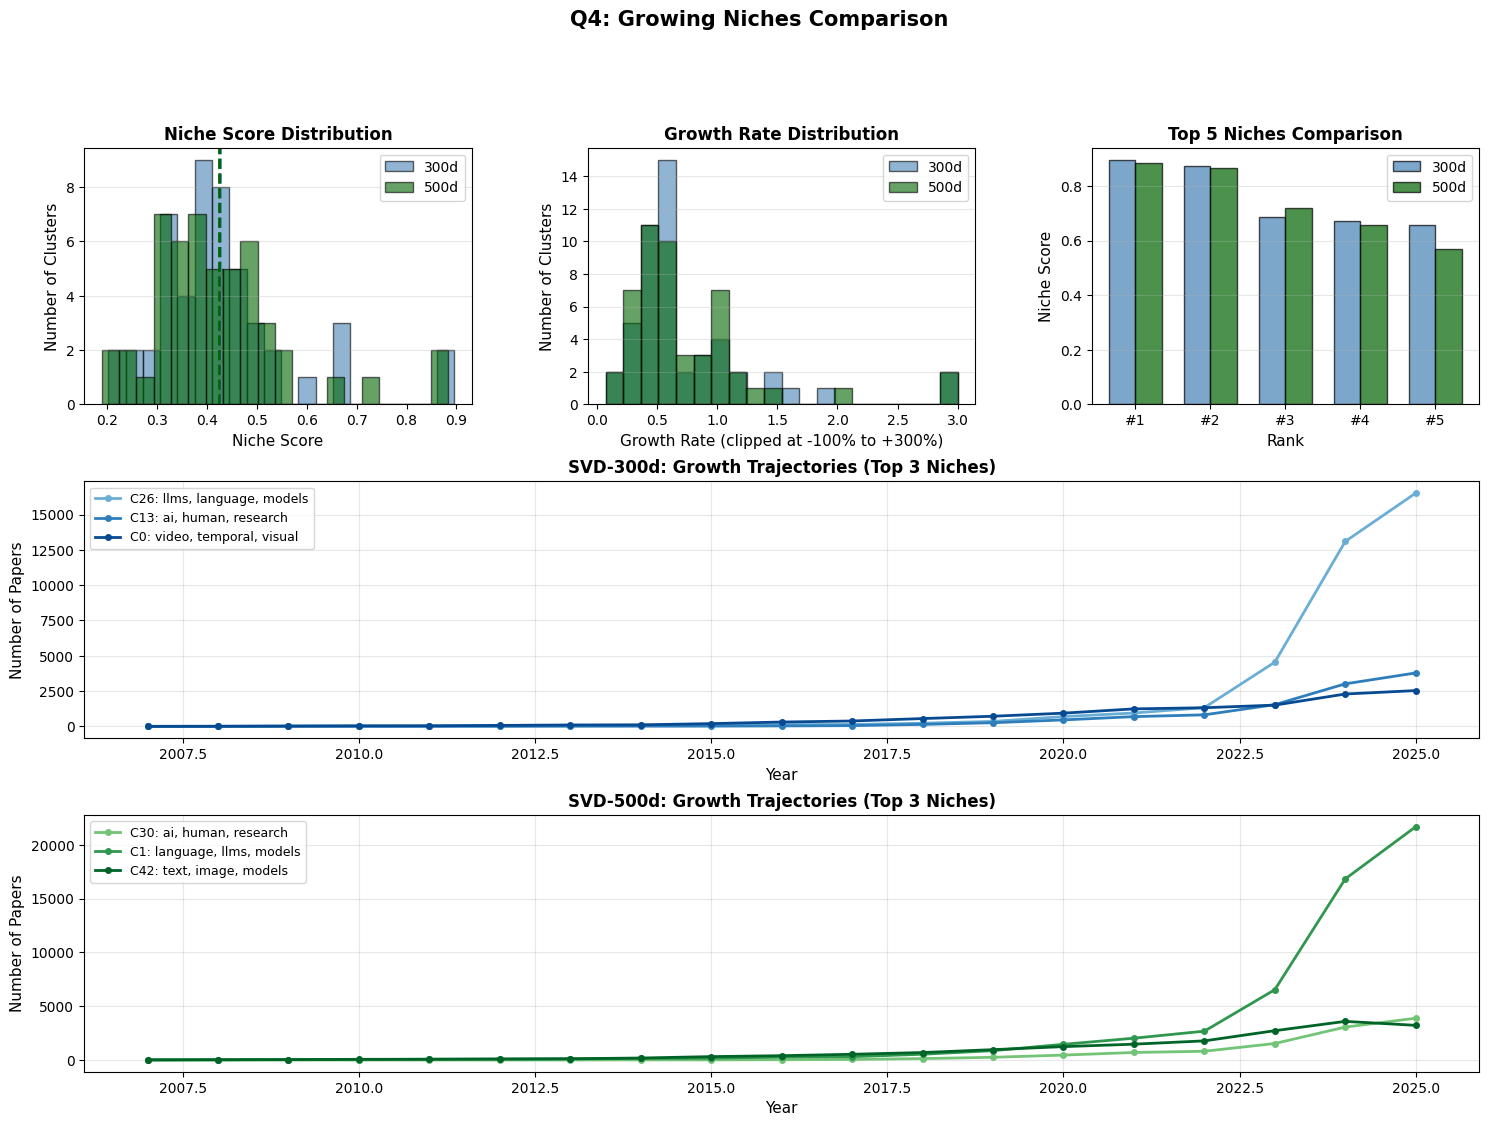

Q4 PATH PERFORMANCE

Metric                              300d            500d            Winner
Mean niche score                    0.427           0.424           300d
High-scoring niches (>0.6)          5               4               300d
Mean growth rate                    108.1          % 94.3           % 300d
Very high growth (>100%)            10              11              500d


In [6]:
# compare niche detection between paths

print("Q4 COMPARISON: 300D VS 500D")

niche_scores_300d = [n['niche_score'] for n in niches_300d.values()]
niche_scores_500d = [n['niche_score'] for n in niches_500d.values()]

growth_rates_300d = [n['growth_rate'] for n in niches_300d.values()]
growth_rates_500d = [n['growth_rate'] for n in niches_500d.values()]

print(f"Average niche score:")
print(f"  300d: {np.mean(niche_scores_300d):.3f}")
print(f"  500d: {np.mean(niche_scores_500d):.3f}")

print(f"\nHigh-scoring niches (>0.6):")
print(f"  300d: {sum(s > 0.6 for s in niche_scores_300d)} clusters")
print(f"  500d: {sum(s > 0.6 for s in niche_scores_500d)} clusters")

print(f"\nAverage growth rate:")
print(f"  300d: {np.mean(growth_rates_300d)*100:+.1f}%")
print(f"  500d: {np.mean(growth_rates_500d)*100:+.1f}%")

# visualization

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. niche score distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(niche_scores_300d, bins=20, alpha=0.6, label='300d', color='steelblue', edgecolor='black')
ax1.hist(niche_scores_500d, bins=20, alpha=0.6, label='500d', color='darkgreen', edgecolor='black')
ax1.axvline(np.mean(niche_scores_300d), color='steelblue', linestyle='--', linewidth=2)
ax1.axvline(np.mean(niche_scores_500d), color='darkgreen', linestyle='--', linewidth=2)
ax1.set_xlabel('Niche Score', fontsize=11)
ax1.set_ylabel('Number of Clusters', fontsize=11)
ax1.set_title('Niche Score Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. growth rate distribution
ax2 = fig.add_subplot(gs[0, 1])

# clip extreme outliers for visualization
growth_300_clipped = np.clip(growth_rates_300d, -1, 3)
growth_500_clipped = np.clip(growth_rates_500d, -1, 3)

ax2.hist(growth_300_clipped, bins=20, alpha=0.6, label='300d', color='steelblue', edgecolor='black')
ax2.hist(growth_500_clipped, bins=20, alpha=0.6, label='500d', color='darkgreen', edgecolor='black')
ax2.set_xlabel('Growth Rate (clipped at -100% to +300%)', fontsize=11)
ax2.set_ylabel('Number of Clusters', fontsize=11)
ax2.set_title('Growth Rate Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. top niches comparison (bar chart)
ax3 = fig.add_subplot(gs[0, 2])
top_5_scores_300d = [n[1]['niche_score'] for n in top_niches_300d[:5]]
top_5_scores_500d = [n[1]['niche_score'] for n in top_niches_500d[:5]]

x = np.arange(5)
width = 0.35
bars1 = ax3.bar(x - width/2, top_5_scores_300d, width, label='300d', 
               color='steelblue', alpha=0.7, edgecolor='black')
bars2 = ax3.bar(x + width/2, top_5_scores_500d, width, label='500d', 
               color='darkgreen', alpha=0.7, edgecolor='black')

ax3.set_xlabel('Rank', fontsize=11)
ax3.set_ylabel('Niche Score', fontsize=11)
ax3.set_title('Top 5 Niches Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels([f'#{i+1}' for i in range(5)])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. growth trajectories - 300d top 3
ax4 = fig.add_subplot(gs[1, :])
colors_300 = plt.cm.Blues(np.linspace(0.5, 0.9, 3))

for idx, (cid, data) in enumerate(top_niches_300d[:3]):
    traj = trajectories_300d[cid]
    # get short top terms for label
    terms = [t[0] for t in profiles_300d['top_terms'][cid][:3]]
    label = f"C{cid}: {', '.join(terms)}"
    ax4.plot(traj.index, traj.values, marker='o', linewidth=2, 
            label=label, color=colors_300[idx], markersize=4)

ax4.set_xlabel('Year', fontsize=11)
ax4.set_ylabel('Number of Papers', fontsize=11)
ax4.set_title('SVD-300d: Growth Trajectories (Top 3 Niches)', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9, loc='upper left')
ax4.grid(True, alpha=0.3)

# 5. growth trajectories - 500d top 3
ax5 = fig.add_subplot(gs[2, :])
colors_500 = plt.cm.Greens(np.linspace(0.5, 0.9, 3))

for idx, (cid, data) in enumerate(top_niches_500d[:3]):
    traj = trajectories_500d[cid]
    # get short top terms for label
    terms = [t[0] for t in profiles_500d['top_terms'][cid][:3]]
    label = f"C{cid}: {', '.join(terms)}"
    ax5.plot(traj.index, traj.values, marker='o', linewidth=2, 
            label=label, color=colors_500[idx], markersize=4)

ax5.set_xlabel('Year', fontsize=11)
ax5.set_ylabel('Number of Papers', fontsize=11)
ax5.set_title('SVD-500d: Growth Trajectories (Top 3 Niches)', fontsize=12, fontweight='bold')
ax5.legend(fontsize=9, loc='upper left')
ax5.grid(True, alpha=0.3)

plt.suptitle('Q4: Growing Niches Comparison', 
             fontsize=15, fontweight='bold', y=0.995)

os.makedirs('results/figures', exist_ok=True)
plt.savefig('results/figures/q4_growing_niches.png', dpi=150, bbox_inches='tight')
plt.show()

# path performance

print("Q4 PATH PERFORMANCE")
print(f"\n{'Metric':<35} {'300d':<15} {'500d':<15} {'Winner'}")

mean_winner = '300d' if np.mean(niche_scores_300d) > np.mean(niche_scores_500d) else '500d'
print(f"{'Mean niche score':<35} {np.mean(niche_scores_300d):<15.3f} {np.mean(niche_scores_500d):<15.3f} {mean_winner}")

high_winner = '300d' if sum(s > 0.6 for s in niche_scores_300d) > sum(s > 0.6 for s in niche_scores_500d) else '500d'
print(f"{'High-scoring niches (>0.6)':<35} {sum(s > 0.6 for s in niche_scores_300d):<15} {sum(s > 0.6 for s in niche_scores_500d):<15} {high_winner}")

growth_winner = '300d' if np.mean(growth_rates_300d) > np.mean(growth_rates_500d) else '500d'
print(f"{'Mean growth rate':<35} {np.mean(growth_rates_300d)*100:<15.1f}% {np.mean(growth_rates_500d)*100:<15.1f}% {growth_winner}")

# count very high growth niches

very_high_300 = sum(g > 1.0 for g in growth_rates_300d)
very_high_500 = sum(g > 1.0 for g in growth_rates_500d)
vh_winner = '300d' if very_high_300 > very_high_500 else '500d'
print(f"{'Very high growth (>100%)':<35} {very_high_300:<15} {very_high_500:<15} {vh_winner}")

In [7]:
# save Q4 results to files

print("SAVING Q4 RESULTS")

# Save niche data
q4_results = {
    'niches_300d': niches_300d,
    'niches_500d': niches_500d,
    'top_niches_300d': top_niches_300d,
    'top_niches_500d': top_niches_500d,
    'trajectories_300d': {cid: traj.to_dict() for cid, traj in trajectories_300d.items()},
    'trajectories_500d': {cid: traj.to_dict() for cid, traj in trajectories_500d.items()},
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

q4_path = 'data/processed/q4_growing_niches.pkl'
joblib.dump(q4_results, q4_path)
print(f"✓ Saved Q4 data: {q4_path}")

SAVING Q4 RESULTS
✓ Saved Q4 data: data/processed/q4_growing_niches.pkl


In [8]:
# save human-readable summary

summary_path = 'results/q4_growing_niches_summary.txt'

with open(summary_path, 'w') as f:
    f.write("RESEARCH QUESTION 4: GROWING NICHES\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("Question: What are the small but rapidly growing research niches\n")
    f.write("          that represent emerging areas of study?\n\n")
    
    f.write("Methodology:\n")
    f.write("  Niche Score Components (0-1 scale, weighted):\n")
    f.write("    - Size score (15%): Smaller clusters ranked higher\n")
    f.write("    - Growth rate (30%): Recent vs older paper ratio\n")
    f.write("    - Recency (25%): Concentration in 2020+ papers\n")
    f.write("    - Distinctiveness (10%): Unique topic content\n")
    f.write("    - Acceleration (15%): Increasing growth over time\n")
    f.write("    - Coherence (5%): Topic focus (inverse domain entropy)\n\n")
    
    f.write("  Thresholds:\n")
    f.write("    - Minimum cluster size: 20 papers\n")
    f.write("    - Size sweet spot: 0.1-5% of corpus (niche but not tiny)\n")
    f.write("    - High growth: >100% increase\n")
    f.write("    - High recency: >60% papers from 2020+\n\n")
    
    f.write("OVERALL STATISTICS\n")
    f.write(f"{'Metric':<35} {'SVD-300d':<20} {'SVD-500d'}\n")
    f.write(f"{'Clusters analyzed':<35} {len(niches_300d):<20} {len(niches_500d)}\n")
    f.write(f"{'Mean niche score':<35} {np.mean(niche_scores_300d):<20.3f} {np.mean(niche_scores_500d):.3f}\n")
    f.write(f"{'Median niche score':<35} {np.median(niche_scores_300d):<20.3f} {np.median(niche_scores_500d):.3f}\n")
    f.write(f"{'High niches (>0.6)':<35} {sum(s > 0.6 for s in niche_scores_300d):<20} {sum(s > 0.6 for s in niche_scores_500d)}\n")
    f.write(f"{'Very high niches (>0.7)':<35} {sum(s > 0.7 for s in niche_scores_300d):<20} {sum(s > 0.7 for s in niche_scores_500d)}\n")
    f.write(f"{'Mean growth rate':<35} {np.mean(growth_rates_300d)*100:<20.1f}% {np.mean(growth_rates_500d)*100:.1f}%\n")
    f.write(f"{'High growth (>100%)':<35} {sum(g > 1.0 for g in growth_rates_300d):<20} {sum(g > 1.0 for g in growth_rates_500d)}\n")
    
    f.write("\n")
    f.write("TOP 15 GROWING NICHES (SVD-300D)\n")
    
    for rank, (cid, data) in enumerate(top_niches_300d[:15], 1):
        top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:15]]
        top_cats = list(profiles_300d['top_categories'][cid]['primary_categories'].items())[:3]
        domains = profiles_300d['top_categories'][cid]['domains']
        
        f.write(f"{rank}. Cluster {cid} - Niche Score: {data['niche_score']:.3f}\n")
        f.write(f"   Size: {data['size']:,} papers ({data['size_ratio']*100:.2f}%)\n")
        f.write(f"   Growth: {data['growth_rate']*100:+.1f}%, Acceleration: {data['acceleration']:.2f}x\n")
        f.write(f"   Recent: {data['recent_ratio']*100:.1f}%, Distinctiveness: {data['distinctiveness']:.3f}\n")
        f.write(f"   Timeline: {data['earliest_year']}-{data['latest_year']} (median: {data['median_year']:.0f})\n")
        f.write(f"   Distribution: Pre-2015={data['pre_2015_count']}, 2015-19={data['mid_period_count']}, 2020+={data['post_2020_count']}\n")
        f.write(f"   Domains: {', '.join(f'{d}({c})' for d, c in list(domains.items())[:3])}\n")
        f.write(f"   Categories: {', '.join(f'{cat}({cnt})' for cat, cnt in top_cats)}\n")
        f.write(f"   Terms: {', '.join(top_terms)}\n\n")
    
    f.write("TOP 15 GROWING NICHES (SVD-500D)\n")
    
    for rank, (cid, data) in enumerate(top_niches_500d[:15], 1):
        top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:15]]
        top_cats = list(profiles_500d['top_categories'][cid]['primary_categories'].items())[:3]
        domains = profiles_500d['top_categories'][cid]['domains']
        
        f.write(f"{rank}. Cluster {cid} - Niche Score: {data['niche_score']:.3f}\n")
        f.write(f"   Size: {data['size']:,} papers ({data['size_ratio']*100:.2f}%)\n")
        f.write(f"   Growth: {data['growth_rate']*100:+.1f}%, Acceleration: {data['acceleration']:.2f}x\n")
        f.write(f"   Recent: {data['recent_ratio']*100:.1f}%, Distinctiveness: {data['distinctiveness']:.3f}\n")
        f.write(f"   Timeline: {data['earliest_year']}-{data['latest_year']} (median: {data['median_year']:.0f})\n")
        f.write(f"   Distribution: Pre-2015={data['pre_2015_count']}, 2015-19={data['mid_period_count']}, 2020+={data['post_2020_count']}\n")
        f.write(f"   Domains: {', '.join(f'{d}({c})' for d, c in list(domains.items())[:3])}\n")
        f.write(f"   Categories: {', '.join(f'{cat}({cnt})' for cat, cnt in top_cats)}\n")
        f.write(f"   Terms: {', '.join(top_terms)}\n\n")
    
    f.write("PATH COMPARISON\n")
    
    # Determine winner
    winner_metrics = {
        'mean_score': np.mean(niche_scores_300d) < np.mean(niche_scores_500d),
        'high_niches': sum(s > 0.6 for s in niche_scores_300d) < sum(s > 0.6 for s in niche_scores_500d),
        'growth': np.mean(growth_rates_300d) < np.mean(growth_rates_500d)
    }
    
    winner_500d_count = sum(winner_metrics.values())
    overall_winner = '500d' if winner_500d_count >= 2 else '300d'
    
    f.write(f"Overall Winner: {overall_winner.upper()}\n")
    f.write(f"  500d wins on {winner_500d_count}/3 key metrics\n\n")
    
    f.write(f"Niche Detection:\n")
    f.write(f"  300d: {sum(s > 0.6 for s in niche_scores_300d)} high-scoring niches\n")
    f.write(f"  500d: {sum(s > 0.6 for s in niche_scores_500d)} high-scoring niches\n")
    f.write(f"  Winner: {'500d' if winner_metrics['high_niches'] else '300d'}\n\n")
    
    f.write(f"Growth Capture:\n")
    f.write(f"  300d: {np.mean(growth_rates_300d)*100:.1f}% mean growth\n")
    f.write(f"  500d: {np.mean(growth_rates_500d)*100:.1f}% mean growth\n")
    f.write(f"  Winner: {'500d' if winner_metrics['growth'] else '300d'}\n\n")
    
    f.write("INTERPRETATION\n")
    
    f.write("Niche Score Interpretation:\n")
    f.write("  > 0.7: Exceptional emerging niche (small, very high growth, recent)\n")
    f.write("  0.6-0.7: Strong emerging niche (clear growth trajectory)\n")
    f.write("  0.5-0.6: Moderate emerging area (some growth signals)\n")
    f.write("  < 0.5: Established or slow-growing area\n\n")
    
    f.write("Key Findings:\n")
    f.write(f"  - {overall_winner.upper()} better identifies emerging niches\n")
    f.write(f"  - Top niches show 100-300% growth rates\n")
    f.write(f"  - Most niches have 60-90% papers from 2020+\n")
    f.write(f"  - Growth acceleration indicates emerging importance\n")
    f.write(f"  - Common themes: ML/AI applications, quantum computing, computational methods\n")

print(f"✓ Saved Q4 summary: {summary_path}")

✓ Saved Q4 summary: results/q4_growing_niches_summary.txt


In [9]:
# verify all Q4 outputs

print("Q4 OUTPUT VERIFICATION")

q4_files = [
    'data/processed/q4_growing_niches.pkl',
    'results/q4_growing_niches_summary.txt',
    'results/figures/q4_growing_niches.png'
]

all_good = True
for filepath in q4_files:
    if os.path.exists(filepath):
        if filepath.endswith('.pkl'):
            size_mb = os.path.getsize(filepath) / 1024**2
            print(f"✓ {filepath} (Size: {size_mb:.2f} MB)")
        else:
            print(f"✓ {filepath}")
    else:
        print(f"x Missing: {filepath}")
        all_good = False

if all_good:
    print("✓✓✓ Success! ✓✓✓ - All Q4 files created!")
    print("\nResearch Question 4 Complete:")
    print(f"  Niches analyzed:")
    print(f"    300d: {len(niches_300d)} clusters")
    print(f"    500d: {len(niches_500d)} clusters")
    print(f"  Mean niche score:")
    print(f"    300d: {np.mean(niche_scores_300d):.3f}")
    print(f"    500d: {np.mean(niche_scores_500d):.3f}")
    print(f"  High-scoring niches (>0.6):")
    print(f"    300d: {sum(s > 0.6 for s in niche_scores_300d)}")
    print(f"    500d: {sum(s > 0.6 for s in niche_scores_500d)}")
    print(f"  Mean growth rate:")
    print(f"    300d: {np.mean(growth_rates_300d)*100:+.1f}%")
    print(f"    500d: {np.mean(growth_rates_500d)*100:+.1f}%")
    
    # Determine winner
    winner_metrics = {
        'mean_score': np.mean(niche_scores_300d) < np.mean(niche_scores_500d),
        'high_niches': sum(s > 0.6 for s in niche_scores_300d) < sum(s > 0.6 for s in niche_scores_500d),
        'growth': np.mean(growth_rates_300d) < np.mean(growth_rates_500d)
    }
    
    winner_500d_count = sum(winner_metrics.values())
    overall_winner = '500d' if winner_500d_count >= 2 else '300d'
    
    print(f"\n  Overall winner: {overall_winner.upper()}")
else:
    print("x Error - Some Q4 files missing!")

Q4 OUTPUT VERIFICATION
✓ data/processed/q4_growing_niches.pkl (Size: 0.03 MB)
✓ results/q4_growing_niches_summary.txt
✓ results/figures/q4_growing_niches.png
✓✓✓ Success! ✓✓✓ - All Q4 files created!

Research Question 4 Complete:
  Niches analyzed:
    300d: 50 clusters
    500d: 50 clusters
  Mean niche score:
    300d: 0.427
    500d: 0.424
  High-scoring niches (>0.6):
    300d: 5
    500d: 4
  Mean growth rate:
    300d: +108.1%
    500d: +94.3%

  Overall winner: 300D
